# 🛠️ Feature Engineering for Telco Customer Churn Prediction

Feature engineering is crucial for improving model performance and robustness by transforming raw data into meaningful representations that capture underlying patterns and relationships. Proper feature engineering can significantly enhance predictive accuracy and model interpretability.

This notebook demonstrates comprehensive feature engineering techniques applied to the Telco Customer Churn dataset, following industry best practices for data preprocessing and transformation.

In [21]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Preprocessing and feature engineering
from sklearn.experimental import enable_iterative_imputer  # noqa: F401
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.preprocessing import (StandardScaler, MinMaxScaler, LabelEncoder, 
                                   OneHotEncoder, PolynomialFeatures, KBinsDiscretizer)
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from scipy import stats
from scipy.stats import boxcox

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('seaborn-v0_8')

print("Libraries imported successfully!")

Libraries imported successfully!


In [22]:
# Load the dataset
train = pd.read_csv('../Data/output/train.csv')
test = pd.read_csv('../Data/output/test.csv')

print("Dataset Overview:")
print(f"Training set shape: {train.shape}")
print(f"Test set shape: {test.shape}")
print(f"\nData types in training set:")
print(train.dtypes)
print(f"\nFirst few rows:")
display(train.head())

Dataset Overview:
Training set shape: (5625, 21)
Test set shape: (1407, 21)

Data types in training set:
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

First few rows:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1830-GGFNM,Male,0,Yes,Yes,65,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,No,No,Two year,No,Credit card (automatic),94.55,6078.75,No
1,4501-VCPFK,Male,0,No,No,26,No,No phone service,DSL,No,No,Yes,Yes,No,No,Month-to-month,No,Electronic check,35.75,1022.50,No
2,8871-JLMHM,Female,0,Yes,No,68,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,No,No,Two year,No,Credit card (automatic),90.20,6297.65,No
3,0225-ZORZP,Male,0,No,No,3,Yes,No,Fiber optic,No,Yes,No,No,No,Yes,Month-to-month,No,Electronic check,84.30,235.05,No
4,1530-ZTDOZ,Female,0,Yes,No,49,No,No phone service,DSL,Yes,No,No,No,Yes,No,Month-to-month,No,Bank transfer (automatic),40.65,2070.75,No


## 1. Data Type Conversion

Converting variables to correct data types is essential for:
- Ensuring proper mathematical operations
- Optimizing memory usage 
- Enabling appropriate preprocessing techniques
- Preventing unexpected behavior in ML algorithms

In [23]:
# Create working copies
train_processed = train.copy()
test_processed = test.copy()

# Convert TotalCharges to numeric (currently stored as string with empty values)
print("Converting TotalCharges to numeric...")
train_processed['TotalCharges'] = pd.to_numeric(train_processed['TotalCharges'], errors='coerce')
test_processed['TotalCharges'] = pd.to_numeric(test_processed['TotalCharges'], errors='coerce')

# Convert SeniorCitizen to categorical (currently numeric 0/1)
print("Converting SeniorCitizen to categorical...")
train_processed['SeniorCitizen'] = train_processed['SeniorCitizen'].astype('category')
test_processed['SeniorCitizen'] = test_processed['SeniorCitizen'].astype('category')

# Convert binary Yes/No columns to categorical
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
for col in binary_cols:
    if col in train_processed.columns:
        train_processed[col] = train_processed[col].astype('category')
    if col in test_processed.columns:
        test_processed[col] = test_processed[col].astype('category')

print("Data type conversion completed!")
print(f"\nUpdated data types:")
print(train_processed.dtypes)

Converting TotalCharges to numeric...
Converting SeniorCitizen to categorical...
Data type conversion completed!

Updated data types:
customerID            object
gender                object
SeniorCitizen       category
Partner             category
Dependents          category
tenure                 int64
PhoneService        category
MultipleLines         object
InternetService       object
OnlineSecurity        object
OnlineBackup          object
DeviceProtection      object
TechSupport           object
StreamingTV           object
StreamingMovies       object
Contract              object
PaperlessBilling    category
PaymentMethod         object
MonthlyCharges       float64
TotalCharges         float64
Churn               category
dtype: object


## 2. Handling Missing Values

Missing values can significantly impact model performance. We'll implement three imputation methods:

**Methods chosen:**
- **Median Imputation**: Robust to outliers, suitable for skewed numerical data
- **KNN Imputation**: Preserves relationships between features, good for correlated variables
- **Iterative Imputation**: Models each feature with missing values as a function of other features

In [24]:
# Check for missing values
print("Missing values analysis:")
missing_train = train_processed.isnull().sum()
print("Training set missing values:")
print(missing_train[missing_train > 0])

# Focus on TotalCharges which has missing values
print(f"\nTotalCharges missing values: {train_processed['TotalCharges'].isnull().sum()}")

# Method 1: Median Imputation (chosen for robustness to outliers)
median_imputer = SimpleImputer(strategy='median')
train_median = train_processed.copy()
test_median = test_processed.copy()

train_median['TotalCharges'] = median_imputer.fit_transform(train_median[['TotalCharges']])
test_median['TotalCharges'] = median_imputer.transform(test_median[['TotalCharges']])

print("✓ Median imputation completed")

# Method 2: KNN Imputation (preserves feature relationships)
# First prepare numeric data for KNN
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
knn_imputer = KNNImputer(n_neighbors=5)

train_knn = train_processed.copy()
test_knn = test_processed.copy()

train_knn[numeric_cols] = knn_imputer.fit_transform(train_knn[numeric_cols])
test_knn[numeric_cols] = knn_imputer.transform(test_knn[numeric_cols])

print("✓ KNN imputation completed")

# For this dataset, we'll proceed with median imputation as it's simpler and effective
train_processed = train_median
test_processed = test_median

print(f"\nVerification - Missing values after imputation: {train_processed['TotalCharges'].isnull().sum()}")

Missing values analysis:
Training set missing values:
Series([], dtype: int64)

TotalCharges missing values: 0
✓ Median imputation completed
✓ KNN imputation completed

Verification - Missing values after imputation: 0


## 3. Detecting and Handling Outliers

Outliers can skew model performance. We'll use IQR method for its interpretability and Z-score for statistical rigor.

**Methods chosen:**
- **IQR Method**: Identifies outliers as values beyond Q1-1.5×IQR or Q3+1.5×IQR
- **Z-score Method**: Identifies outliers as values with |z-score| > 3

In [25]:
# Define numeric columns for outlier detection
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Method 1: IQR Method
def detect_outliers_iqr(df, columns):
    outlier_indices = set()
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        col_outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index
        outlier_indices.update(col_outliers)
        print(f"{col}: {len(col_outliers)} outliers detected (Range: {lower_bound:.2f} to {upper_bound:.2f})")
    
    return list(outlier_indices)

# Method 2: Z-score Method
def detect_outliers_zscore(df, columns, threshold=3):
    outlier_indices = set()
    for col in columns:
        z_scores = np.abs(stats.zscore(df[col]))
        col_outliers = df[z_scores > threshold].index
        outlier_indices.update(col_outliers)
        print(f"{col}: {len(col_outliers)} outliers detected (|z-score| > {threshold})")
    
    return list(outlier_indices)

print("IQR Method Results:")
iqr_outliers = detect_outliers_iqr(train_processed, numeric_cols)

print(f"\nZ-score Method Results:")
zscore_outliers = detect_outliers_zscore(train_processed, numeric_cols)

print(f"\nTotal outliers (IQR): {len(iqr_outliers)}")
print(f"Total outliers (Z-score): {len(zscore_outliers)}")

# For this telecom dataset, we'll cap outliers rather than remove them to preserve data
# Cap outliers using IQR method (more conservative)
for col in numeric_cols:
    Q1 = train_processed[col].quantile(0.25)
    Q3 = train_processed[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Cap outliers
    train_processed[col] = train_processed[col].clip(lower=lower_bound, upper=upper_bound)
    test_processed[col] = test_processed[col].clip(lower=lower_bound, upper=upper_bound)

print("✓ Outliers capped using IQR method")

IQR Method Results:
tenure: 0 outliers detected (Range: -61.50 to 126.50)
MonthlyCharges: 0 outliers detected (Range: -45.58 to 171.43)
TotalCharges: 0 outliers detected (Range: -4670.05 to 8884.75)

Z-score Method Results:
tenure: 0 outliers detected (|z-score| > 3)
MonthlyCharges: 0 outliers detected (|z-score| > 3)
TotalCharges: 0 outliers detected (|z-score| > 3)

Total outliers (IQR): 0
Total outliers (Z-score): 0
✓ Outliers capped using IQR method


## 4. Polynomial Features

Polynomial features help capture non-linear relationships between variables. For example, the relationship between tenure and churn might not be linear - customers might be more likely to churn in early months, then loyalty increases, but may decrease again for very long tenures.

**Degree=2 chosen** to balance complexity and interpretability while capturing quadratic relationships.

In [26]:
# Generate polynomial features for numeric columns
poly_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Create polynomial features (degree=2)
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)

# Fit on training data
train_poly_features = poly.fit_transform(train_processed[poly_cols])
test_poly_features = poly.transform(test_processed[poly_cols])

# Get feature names
poly_feature_names = poly.get_feature_names_out(poly_cols)

# Create DataFrames for polynomial features
train_poly_df = pd.DataFrame(train_poly_features, columns=poly_feature_names, index=train_processed.index)
test_poly_df = pd.DataFrame(test_poly_features, columns=poly_feature_names, index=test_processed.index)

print("Polynomial features generated:")
print(f"Original features: {len(poly_cols)}")
print(f"Polynomial features: {len(poly_feature_names)}")
print(f"Feature names: {list(poly_feature_names)}")

# Add polynomial features to main datasets
for col in poly_feature_names:
    if col not in poly_cols:  # Avoid duplicating original features
        train_processed[f'poly_{col}'] = train_poly_df[col]
        test_processed[f'poly_{col}'] = test_poly_df[col]

print("✓ Polynomial features added to dataset")

Polynomial features generated:
Original features: 3
Polynomial features: 9
Feature names: ['tenure', 'MonthlyCharges', 'TotalCharges', 'tenure^2', 'tenure MonthlyCharges', 'tenure TotalCharges', 'MonthlyCharges^2', 'MonthlyCharges TotalCharges', 'TotalCharges^2']
✓ Polynomial features added to dataset


## 5. Interaction Features

Interaction features capture relationships between variables that individual features cannot represent. For telecom customers, meaningful interactions might reveal combined effects of multiple factors on churn behavior.

**Rationale for chosen interactions:**
- `tenure × MonthlyCharges`: Long-term customers paying high fees might have different churn patterns
- `MonthlyCharges × TotalCharges`: Relationship between monthly spend and total lifetime value

In [27]:
# Create meaningful interaction features

# Interaction 1: tenure × MonthlyCharges
# Captures the relationship between customer loyalty and spending level
train_processed['tenure_x_monthly'] = train_processed['tenure'] * train_processed['MonthlyCharges']
test_processed['tenure_x_monthly'] = test_processed['tenure'] * test_processed['MonthlyCharges']

# Interaction 2: MonthlyCharges × TotalCharges relationship
# Helps identify spending consistency patterns
train_processed['monthly_x_total'] = train_processed['MonthlyCharges'] * train_processed['TotalCharges']
test_processed['monthly_x_total'] = test_processed['MonthlyCharges'] * test_processed['TotalCharges']

# Interaction 3: tenure × TotalCharges (derived relationship)
# Captures total customer value over time
train_processed['tenure_x_total'] = train_processed['tenure'] * train_processed['TotalCharges']
test_processed['tenure_x_total'] = test_processed['tenure'] * test_processed['TotalCharges']

print("Interaction features created:")
interaction_features = ['tenure_x_monthly', 'monthly_x_total', 'tenure_x_total']
for feature in interaction_features:
    train_stats = train_processed[feature].describe()
    print(f"\n{feature}:")
    print(f"  Mean: {train_stats['mean']:.2f}")
    print(f"  Std:  {train_stats['std']:.2f}")
    print(f"  Range: [{train_stats['min']:.2f}, {train_stats['max']:.2f}]")

print("✓ Interaction features added to dataset")

Interaction features created:

tenure_x_monthly:
  Mean: 2301.53
  Std:  2273.47
  Range: [18.80, 8510.40]

monthly_x_total:
  Mean: 194319.67
  Std:  238681.22
  Range: [353.44, 1023069.44]

tenure_x_total:
  Mean: 121141.72
  Std:  157918.42
  Range: [18.80, 625305.60]
✓ Interaction features added to dataset


## 6. Domain-Specific Features

Domain knowledge helps create features that capture business-relevant patterns in telecom customer behavior.

**Domain-specific features with business rationale:**
- **AverageMonthlyCharge**: TotalCharges ÷ tenure - indicates spending consistency and value perception
- **CustomerLoyaltyIndex**: Combination of tenure and service portfolio - measures customer stickiness
- **ServiceDiversityScore**: Number of services used - higher diversity often correlates with lower churn

In [28]:
# Domain-Specific Feature 1: Average Monthly Charge
# Rationale: Customers with high average charges relative to tenure might be more price-sensitive
def calculate_avg_monthly_charge(row):
    if row['tenure'] > 0:
        return row['TotalCharges'] / row['tenure']
    else:
        return row['MonthlyCharges']  # For new customers (tenure=0)

train_processed['AvgMonthlyCharge'] = train_processed.apply(calculate_avg_monthly_charge, axis=1)
test_processed['AvgMonthlyCharge'] = test_processed.apply(calculate_avg_monthly_charge, axis=1)

# Domain-Specific Feature 2: Service Diversity Score
# Rationale: Customers using more services have higher switching costs
service_cols = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 
                'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

def calculate_service_diversity(row):
    score = 0
    # Phone service
    if row['PhoneService'] == 'Yes':
        score += 1
    # Multiple lines
    if row['MultipleLines'] == 'Yes':
        score += 1
    # Internet service
    if row['InternetService'] in ['DSL', 'Fiber optic']:
        score += 1
    # Add-on services
    addon_services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
    for service in addon_services:
        if row[service] == 'Yes':
            score += 1
    return score

train_processed['ServiceDiversityScore'] = train_processed.apply(calculate_service_diversity, axis=1)
test_processed['ServiceDiversityScore'] = test_processed.apply(calculate_service_diversity, axis=1)

# Domain-Specific Feature 3: Customer Stability Index
# Rationale: Combines tenure with contract type to measure customer stability
def calculate_stability_index(row):
    base_score = row['tenure']
    # Multiply by contract type multiplier
    if row['Contract'] == 'Month-to-month':
        multiplier = 1.0
    elif row['Contract'] == 'One year':
        multiplier = 1.5
    elif row['Contract'] == 'Two year':
        multiplier = 2.0
    else:
        multiplier = 1.0
    return base_score * multiplier

train_processed['StabilityIndex'] = train_processed.apply(calculate_stability_index, axis=1)
test_processed['StabilityIndex'] = test_processed.apply(calculate_stability_index, axis=1)

print("Domain-specific features created:")
domain_features = ['AvgMonthlyCharge', 'ServiceDiversityScore', 'StabilityIndex']
for feature in domain_features:
    stats = train_processed[feature].describe()
    print(f"\n{feature}:")
    print(f"  Mean: {stats['mean']:.2f}")
    print(f"  Range: [{stats['min']:.2f}, {stats['max']:.2f}]")

print("✓ Domain-specific features added to dataset")

Domain-specific features created:

AvgMonthlyCharge:
  Mean: 65.00
  Range: [13.78, 121.40]

ServiceDiversityScore:
  Mean: 4.17
  Range: [1.00, 9.00]

StabilityIndex:
  Mean: 50.76
  Range: [1.00, 144.00]
✓ Domain-specific features added to dataset


## 7. Log Transformation

Log transformation helps normalize skewed distributions and can improve model performance by making relationships more linear.

**TotalCharges chosen** for log transformation due to its right-skewed distribution (typical in financial data where most customers have moderate charges but some have very high charges).

In [29]:
# Check skewness of numeric variables
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

print("Skewness analysis:")
for col in numeric_features:
    skewness = train_processed[col].skew()
    print(f"{col}: {skewness:.3f}")

# Apply log transformation to TotalCharges (most skewed)
# Add 1 to handle any zero values
train_processed['log_TotalCharges'] = np.log1p(train_processed['TotalCharges'])
test_processed['log_TotalCharges'] = np.log1p(test_processed['TotalCharges'])

# Verify transformation effect
original_skew = train_processed['TotalCharges'].skew()
transformed_skew = train_processed['log_TotalCharges'].skew()

print(f"\nLog transformation results for TotalCharges:")
print(f"Original skewness: {original_skew:.3f}")
print(f"Transformed skewness: {transformed_skew:.3f}")
print(f"Skewness reduction: {abs(original_skew) - abs(transformed_skew):.3f}")

# Optional: Apply log transformation to other skewed features if needed
if train_processed['MonthlyCharges'].skew() > 1:
    train_processed['log_MonthlyCharges'] = np.log1p(train_processed['MonthlyCharges'])
    test_processed['log_MonthlyCharges'] = np.log1p(test_processed['MonthlyCharges'])
    print("✓ Log transformation also applied to MonthlyCharges")

print("✓ Log transformation completed")

Skewness analysis:
tenure: 0.237
MonthlyCharges: -0.230
TotalCharges: 0.954

Log transformation results for TotalCharges:
Original skewness: 0.954
Transformed skewness: -0.754
Skewness reduction: 0.201
✓ Log transformation completed


## 8. Normalization

Normalization scales features to a fixed range [0,1], which is essential for:
- Distance-based algorithms (KNN, SVM)
- Neural networks
- Algorithms sensitive to feature magnitude

**tenure chosen** for normalization as it has a clear bounded interpretation (0 to max_tenure) and benefits from 0-1 scaling.

In [30]:
# Apply MinMax normalization to tenure
# Rationale: tenure has natural bounds (0 to maximum) and benefits from 0-1 scaling

normalizer = MinMaxScaler()

# Normalize tenure
train_processed['normalized_tenure'] = normalizer.fit_transform(train_processed[['tenure']])
test_processed['normalized_tenure'] = normalizer.transform(test_processed[['tenure']])

print("Normalization results for tenure:")
print(f"Original range: [{train_processed['tenure'].min():.0f}, {train_processed['tenure'].max():.0f}]")
print(f"Normalized range: [{train_processed['normalized_tenure'].min():.3f}, {train_processed['normalized_tenure'].max():.3f}]")

# Also normalize the newly created features that might benefit from 0-1 scaling
features_to_normalize = ['ServiceDiversityScore', 'StabilityIndex']

for feature in features_to_normalize:
    scaler = MinMaxScaler()
    train_processed[f'normalized_{feature}'] = scaler.fit_transform(train_processed[[feature]])
    test_processed[f'normalized_{feature}'] = scaler.transform(test_processed[[feature]])
    
    print(f"\n{feature}:")
    print(f"Original range: [{train_processed[feature].min():.2f}, {train_processed[feature].max():.2f}]")
    print(f"Normalized range: [{train_processed[f'normalized_{feature}'].min():.3f}, {train_processed[f'normalized_{feature}'].max():.3f}]")

print("✓ Normalization completed")

Normalization results for tenure:
Original range: [1, 72]
Normalized range: [0.000, 1.000]

ServiceDiversityScore:
Original range: [1.00, 9.00]
Normalized range: [0.000, 1.000]

StabilityIndex:
Original range: [1.00, 144.00]
Normalized range: [0.000, 1.000]
✓ Normalization completed


## 9. Standardization

Standardization transforms features to have zero mean and unit variance, which is beneficial for:
- Linear models (Logistic Regression, SVM)
- Algorithms assuming normal distribution
- Principal Component Analysis (PCA)

**MonthlyCharges chosen** for standardization as it represents continuous pricing data that benefits from z-score normalization.

In [31]:
# Apply standardization to MonthlyCharges
# Rationale: MonthlyCharges is continuous pricing data that benefits from z-score transformation

standardizer = StandardScaler()

# Standardize MonthlyCharges
train_processed['standardized_MonthlyCharges'] = standardizer.fit_transform(train_processed[['MonthlyCharges']])
test_processed['standardized_MonthlyCharges'] = standardizer.transform(test_processed[['MonthlyCharges']])

print("Standardization results for MonthlyCharges:")
print(f"Original - Mean: {train_processed['MonthlyCharges'].mean():.2f}, Std: {train_processed['MonthlyCharges'].std():.2f}")
print(f"Standardized - Mean: {train_processed['standardized_MonthlyCharges'].mean():.6f}, Std: {train_processed['standardized_MonthlyCharges'].std():.6f}")

# Also standardize the average monthly charge feature
avg_scaler = StandardScaler()
train_processed['standardized_AvgMonthlyCharge'] = avg_scaler.fit_transform(train_processed[['AvgMonthlyCharge']])
test_processed['standardized_AvgMonthlyCharge'] = avg_scaler.transform(test_processed[['AvgMonthlyCharge']])

print(f"\nAvgMonthlyCharge:")
print(f"Original - Mean: {train_processed['AvgMonthlyCharge'].mean():.2f}, Std: {train_processed['AvgMonthlyCharge'].std():.2f}")
print(f"Standardized - Mean: {train_processed['standardized_AvgMonthlyCharge'].mean():.6f}, Std: {train_processed['standardized_AvgMonthlyCharge'].std():.6f}")

print("✓ Standardization completed")

Standardization results for MonthlyCharges:
Original - Mean: 65.00, Std: 30.11
Standardized - Mean: 0.000000, Std: 1.000089

AvgMonthlyCharge:
Original - Mean: 65.00, Std: 30.23
Standardized - Mean: -0.000000, Std: 1.000089
✓ Standardization completed


## 10. Encoding Categorical Features

Different encoding methods are suitable for different types of categorical variables:

**Encoding methods and their applications:**
- **One-Hot Encoding**: For nominal variables with no inherent order (InternetService, PaymentMethod)
- **Label Encoding**: For ordinal variables with meaningful order (Contract duration)
- **Frequency Encoding**: For high-cardinality categories where frequency matters (could be useful for rare categories)

In [32]:
# Method 1: One-Hot Encoding for nominal variables
# Suitable for: InternetService, PaymentMethod (no inherent order)

nominal_cols = ['InternetService', 'PaymentMethod']

print("One-Hot Encoding:")
for col in nominal_cols:
    if col in train_processed.columns:
        # Create one-hot encoded features
        train_dummies = pd.get_dummies(train_processed[col], prefix=f'onehot_{col}', drop_first=True)
        test_dummies = pd.get_dummies(test_processed[col], prefix=f'onehot_{col}', drop_first=True)
        
        # Align columns between train and test
        train_dummies, test_dummies = train_dummies.align(test_dummies, join='left', axis=1, fill_value=0)
        
        # Add to main datasets
        train_processed = pd.concat([train_processed, train_dummies], axis=1)
        test_processed = pd.concat([test_processed, test_dummies], axis=1)
        
        print(f"  {col}: {len(train_dummies.columns)} features created")

# Method 2: Label Encoding for ordinal variables
# Suitable for: Contract (has natural order: Month-to-month < One year < Two year)

print("\nLabel Encoding:")
contract_mapping = {'Month-to-month': 0, 'One year': 1, 'Two year': 2}
train_processed['label_Contract'] = train_processed['Contract'].map(contract_mapping)
test_processed['label_Contract'] = test_processed['Contract'].map(contract_mapping)
print(f"  Contract: Mapped to {contract_mapping}")

# Method 3: Frequency Encoding
# Suitable for: Variables where frequency of occurrence matters

print("\nFrequency Encoding:")
freq_cols = ['gender', 'PaymentMethod']

for col in freq_cols:
    if col in train_processed.columns:
        # Calculate frequency in training set
        freq_map = train_processed[col].value_counts(normalize=True).to_dict()
        
        # Apply frequency encoding
        train_processed[f'freq_{col}'] = train_processed[col].map(freq_map)
        test_processed[f'freq_{col}'] = test_processed[col].map(freq_map)
        
        print(f"  {col}: Frequency mapping applied")
        print(f"    Frequencies: {freq_map}")

print("✓ Categorical encoding completed")

One-Hot Encoding:
  InternetService: 2 features created
  PaymentMethod: 3 features created

Label Encoding:
  Contract: Mapped to {'Month-to-month': 0, 'One year': 1, 'Two year': 2}

Frequency Encoding:
  gender: Frequency mapping applied
    Frequencies: {'Male': 0.5018666666666667, 'Female': 0.4981333333333333}
  PaymentMethod: Frequency mapping applied
    Frequencies: {'Electronic check': 0.3390222222222222, 'Mailed check': 0.22542222222222222, 'Bank transfer (automatic)': 0.21955555555555556, 'Credit card (automatic)': 0.216}
✓ Categorical encoding completed


## 11. Binning

Binning converts continuous variables into discrete categories, which can:
- Reduce noise and outlier impact
- Capture non-linear relationships
- Make models more interpretable

**Binning strategies and rationale:**
- **Equal Width Binning**: For MonthlyCharges - creates uniform price ranges
- **Equal Frequency Binning**: For TotalCharges - ensures balanced groups
- **Custom Binning**: For tenure - uses domain knowledge about customer lifecycle stages

In [33]:
# Method 1: Equal Width Binning for MonthlyCharges
# Rationale: Creates uniform price ranges for easy interpretation

equal_width_binner = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
train_processed['equal_width_MonthlyCharges'] = equal_width_binner.fit_transform(train_processed[['MonthlyCharges']])
test_processed['equal_width_MonthlyCharges'] = equal_width_binner.transform(test_processed[['MonthlyCharges']])

# Get bin edges for interpretation
bin_edges = equal_width_binner.bin_edges_[0]
print("Equal Width Binning (MonthlyCharges):")
for i in range(len(bin_edges)-1):
    print(f"  Bin {i}: ${bin_edges[i]:.2f} - ${bin_edges[i+1]:.2f}")

# Method 2: Equal Frequency Binning for TotalCharges
# Rationale: Ensures each bin has roughly the same number of customers

equal_freq_binner = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')
train_processed['equal_freq_TotalCharges'] = equal_freq_binner.fit_transform(train_processed[['TotalCharges']])
test_processed['equal_freq_TotalCharges'] = equal_freq_binner.transform(test_processed[['TotalCharges']])

# Show frequency distribution
print(f"\nEqual Frequency Binning (TotalCharges):")
freq_distribution = train_processed['equal_freq_TotalCharges'].value_counts().sort_index()
print("Bin distribution:")
for bin_num, count in freq_distribution.items():
    percentage = (count / len(train_processed)) * 100
    print(f"  Bin {int(bin_num)}: {count} customers ({percentage:.1f}%)")

# Method 3: Custom Binning for tenure based on domain knowledge
# Rationale: Business-meaningful customer lifecycle stages

def custom_tenure_binning(tenure):
    """Custom binning based on telecom industry knowledge"""
    if tenure <= 6:
        return 0  # New customers (0-6 months) - high churn risk
    elif tenure <= 12:
        return 1  # Early customers (6-12 months) - stabilizing
    elif tenure <= 24:
        return 2  # Established customers (1-2 years) - loyal
    elif tenure <= 48:
        return 3  # Long-term customers (2-4 years) - very loyal
    else:
        return 4  # Veteran customers (4+ years) - most loyal

train_processed['custom_tenure_bins'] = train_processed['tenure'].apply(custom_tenure_binning)
test_processed['custom_tenure_bins'] = test_processed['tenure'].apply(custom_tenure_binning)

print(f"\nCustom Binning (tenure):")
custom_distribution = train_processed['custom_tenure_bins'].value_counts().sort_index()
bin_labels = ['New (0-6m)', 'Early (6-12m)', 'Established (1-2y)', 'Long-term (2-4y)', 'Veteran (4y+)']
for bin_num, count in custom_distribution.items():
    percentage = (count / len(train_processed)) * 100
    print(f"  {bin_labels[bin_num]}: {count} customers ({percentage:.1f}%)")

# Create one-hot encoded versions of binned features for better model compatibility
for feature in ['equal_width_MonthlyCharges', 'equal_freq_TotalCharges', 'custom_tenure_bins']:
    train_binned = pd.get_dummies(train_processed[feature], prefix=f'binned_{feature}')
    test_binned = pd.get_dummies(test_processed[feature], prefix=f'binned_{feature}')
    
    # Align columns
    train_binned, test_binned = train_binned.align(test_binned, join='left', axis=1, fill_value=0)
    
    train_processed = pd.concat([train_processed, train_binned], axis=1)
    test_processed = pd.concat([test_processed, test_binned], axis=1)

print("✓ Binning completed with one-hot encoded versions created")

Equal Width Binning (MonthlyCharges):
  Bin 0: $18.40 - $38.45
  Bin 1: $38.45 - $58.50
  Bin 2: $58.50 - $78.55
  Bin 3: $78.55 - $98.60
  Bin 4: $98.60 - $118.65

Equal Frequency Binning (TotalCharges):
Bin distribution:
  Bin 0: 1406 customers (25.0%)
  Bin 1: 1405 customers (25.0%)
  Bin 2: 1407 customers (25.0%)
  Bin 3: 1407 customers (25.0%)

Custom Binning (tenure):
  New (0-6m): 1148 customers (20.4%)
  Early (6-12m): 576 customers (10.2%)
  Established (1-2y): 818 customers (14.5%)
  Long-term (2-4y): 1279 customers (22.7%)
  Veteran (4y+): 1804 customers (32.1%)


✓ Binning completed with one-hot encoded versions created


## 🎯 Feature Engineering Summary

This comprehensive feature engineering process has transformed the original dataset through multiple sophisticated techniques, creating a rich feature set ready for machine learning modeling.

In [34]:
# Final dataset overview
print("🎯 FEATURE ENGINEERING COMPLETE")
print("="*50)

print(f"\nDataset Transformation:")
print(f"Original features: {train.shape[1]}")
print(f"Final features: {train_processed.shape[1]}")
print(f"Features added: {train_processed.shape[1] - train.shape[1]}")

print(f"\nFeature Engineering Techniques Applied:")
techniques_applied = [
    "✓ Data Type Conversion",
    "✓ Missing Value Imputation (Median)",
    "✓ Outlier Detection & Handling (IQR)",
    "✓ Polynomial Features (degree=2)",
    "✓ Interaction Features (3 created)",
    "✓ Domain-Specific Features (3 created)",
    "✓ Log Transformation",
    "✓ Normalization (MinMax)",
    "✓ Standardization (Z-score)",
    "✓ One-Hot Encoding",
    "✓ Label Encoding", 
    "✓ Frequency Encoding",
    "✓ Equal Width Binning",
    "✓ Equal Frequency Binning",
    "✓ Custom Domain Binning"
]

for technique in techniques_applied:
    print(f"  {technique}")

print(f"\nKey Engineered Features Created:")
engineered_features = [
    "tenure_x_monthly", "monthly_x_total", "tenure_x_total",  # Interactions
    "AvgMonthlyCharge", "ServiceDiversityScore", "StabilityIndex",  # Domain-specific
    "log_TotalCharges", "normalized_tenure", "standardized_MonthlyCharges",  # Transformations
    "label_Contract", "freq_gender", "custom_tenure_bins"  # Encodings
]

for i, feature in enumerate(engineered_features, 1):
    print(f"  {i:2d}. {feature}")

print(f"\nDataset Ready for Modeling:")
print(f"Training samples: {train_processed.shape[0]:,}")
print(f"Test samples: {test_processed.shape[0]:,}")
print(f"Total features: {train_processed.shape[1]:,}")

# Save the processed datasets
train_processed.to_csv('../Data/interim/train_engineered.csv', index=False)
test_processed.to_csv('../Data/interim/test_engineered.csv', index=False)

print(f"\n✅ Processed datasets saved:")
print(f"   📁 ../Data/interim/train_engineered.csv")
print(f"   📁 ../Data/interim/test_engineered.csv")

🎯 FEATURE ENGINEERING COMPLETE

Dataset Transformation:
Original features: 21
Final features: 64
Features added: 43

Feature Engineering Techniques Applied:
  ✓ Data Type Conversion
  ✓ Missing Value Imputation (Median)
  ✓ Outlier Detection & Handling (IQR)
  ✓ Polynomial Features (degree=2)
  ✓ Interaction Features (3 created)
  ✓ Domain-Specific Features (3 created)
  ✓ Log Transformation
  ✓ Normalization (MinMax)
  ✓ Standardization (Z-score)
  ✓ One-Hot Encoding
  ✓ Label Encoding
  ✓ Frequency Encoding
  ✓ Equal Width Binning
  ✓ Equal Frequency Binning
  ✓ Custom Domain Binning

Key Engineered Features Created:
   1. tenure_x_monthly
   2. monthly_x_total
   3. tenure_x_total
   4. AvgMonthlyCharge
   5. ServiceDiversityScore
   6. StabilityIndex
   7. log_TotalCharges
   8. normalized_tenure
   9. standardized_MonthlyCharges
  10. label_Contract
  11. freq_gender
  12. custom_tenure_bins

Dataset Ready for Modeling:
Training samples: 5,625
Test samples: 1,407
Total features: 6

## 🎯 Feature Selection

Feature selection is crucial for improving model performance and reducing complexity by:
- **Eliminating redundant features** that don't contribute to predictive power
- **Reducing overfitting** by focusing on the most relevant variables
- **Improving computational efficiency** and training speed
- **Enhancing model interpretability** by working with fewer, more meaningful features

We'll implement three complementary feature selection approaches to identify the optimal feature subset.

In [35]:
# Prepare data for feature selection
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import os

# Separate features and target
# Exclude non-predictive columns
exclude_cols = ['customerID', 'Churn']
X_train = train_processed.drop(columns=exclude_cols, errors='ignore')
y_train = train_processed['Churn'].map({'Yes': 1, 'No': 0})  # Convert to binary

X_test = test_processed.drop(columns=exclude_cols, errors='ignore')
y_test = test_processed['Churn'].map({'Yes': 1, 'No': 0})

# Handle any remaining categorical variables by converting to numeric
for col in X_train.columns:
    if X_train[col].dtype == 'object' or X_train[col].dtype.name == 'category':
        # Use label encoding for remaining categorical variables
        le = LabelEncoder()
        X_train[col] = le.fit_transform(X_train[col].astype(str))
        X_test[col] = le.transform(X_test[col].astype(str))

print(f"Feature selection dataset prepared:")
print(f"Training features shape: {X_train.shape}")
print(f"Test features shape: {X_test.shape}")
print(f"Target distribution: {y_train.value_counts()}")
print(f"Feature types: {X_train.dtypes.value_counts()}")

Feature selection dataset prepared:
Training features shape: (5625, 62)
Test features shape: (1407, 62)
Target distribution: Churn
0    4130
1    1495
Name: count, dtype: int64
Feature types: float64    23
int64      20
bool       19
Name: count, dtype: int64

Training features shape: (5625, 62)
Test features shape: (1407, 62)
Target distribution: Churn
0    4130
1    1495
Name: count, dtype: int64
Feature types: float64    23
int64      20
bool       19
Name: count, dtype: int64


### 1. Filter Methods

Filter methods evaluate features independently based on statistical measures. They're computationally efficient and model-agnostic.

**Methods implemented:**
- **ANOVA F-test**: Measures linear relationship between features and target
- **Mutual Information**: Captures both linear and non-linear relationships
- **Correlation Analysis**: Identifies features highly correlated with target

In [36]:
# Method 1: ANOVA F-test
# Measures the linear relationship between each feature and the target
k_best = 20  # Select top 20 features
f_selector = SelectKBest(score_func=f_classif, k=k_best)
X_train_f = f_selector.fit_transform(X_train, y_train)
X_test_f = f_selector.transform(X_test)

# Get selected feature names and scores
f_selected_features = X_train.columns[f_selector.get_support()]
f_scores = f_selector.scores_[f_selector.get_support()]

print("ANOVA F-test Results:")
print(f"Selected {len(f_selected_features)} features out of {X_train.shape[1]}")
f_results = pd.DataFrame({
    'Feature': f_selected_features,
    'F_Score': f_scores
}).sort_values('F_Score', ascending=False)
print("Top 10 features by F-score:")
display(f_results.head(10))

# Method 2: Mutual Information
# Captures both linear and non-linear relationships
mi_selector = SelectKBest(score_func=mutual_info_classif, k=k_best)
X_train_mi = mi_selector.fit_transform(X_train, y_train)
X_test_mi = mi_selector.transform(X_test)

mi_selected_features = X_train.columns[mi_selector.get_support()]
mi_scores = mi_selector.scores_[mi_selector.get_support()]

print(f"\nMutual Information Results:")
print(f"Selected {len(mi_selected_features)} features out of {X_train.shape[1]}")
mi_results = pd.DataFrame({
    'Feature': mi_selected_features,
    'MI_Score': mi_scores
}).sort_values('MI_Score', ascending=False)
print("Top 10 features by Mutual Information:")
display(mi_results.head(10))

# Method 3: Correlation Analysis
# Calculate correlation with target variable
correlations = []
for col in X_train.columns:
    corr = abs(X_train[col].corr(y_train))
    correlations.append((col, corr))

corr_results = pd.DataFrame(correlations, columns=['Feature', 'Abs_Correlation']).sort_values('Abs_Correlation', ascending=False)
corr_selected_features = corr_results.head(k_best)['Feature'].tolist()

print(f"\nCorrelation Analysis Results:")
print(f"Selected {len(corr_selected_features)} features out of {X_train.shape[1]}")
print("Top 10 features by correlation:")
display(corr_results.head(10))

# Find common features across all filter methods
common_filter_features = set(f_selected_features) & set(mi_selected_features) & set(corr_selected_features)
print(f"\nCommon features across all filter methods: {len(common_filter_features)}")
print(f"Features: {list(common_filter_features)}")

print("✓ Filter methods completed")

ANOVA F-test Results:
Selected 20 features out of 62
Top 10 features by F-score:

Selected 20 features out of 62
Top 10 features by F-score:


,Feature,F_Score
3,Contract,1074.237818
14,label_Contract,1074.237818
7,StabilityIndex,883.043094
10,normalized_StabilityIndex,883.043094
17,custom_tenure_bins,852.540098
0,tenure,793.753490
9,normalized_tenure,793.753490
4,poly_tenure^2,619.840104
18,binned_custom_tenure_bins_0,595.402544
15,freq_PaymentMethod,583.290552



Mutual Information Results:
Selected 20 features out of 62
Top 10 features by Mutual Information:


,Feature,MI_Score
18,label_Contract,0.102133
15,normalized_StabilityIndex,0.094300
5,Contract,0.094254
12,StabilityIndex,0.090091
14,normalized_tenure,0.078351
7,poly_tenure^2,0.072967
1,InternetService,0.064873
19,custom_tenure_bins,0.063652
2,OnlineSecurity,0.060153
0,tenure,0.057673



Correlation Analysis Results:
Selected 20 features out of 62
Top 10 features by correlation:


,Feature,Abs_Correlation
14,Contract,0.400500
42,label_Contract,0.400500
34,normalized_StabilityIndex,0.368411
30,StabilityIndex,0.368411
47,custom_tenure_bins,0.362844
32,normalized_tenure,0.351710
4,tenure,0.351710
19,poly_tenure^2,0.315100
57,binned_custom_tenure_bins_0,0.309433
44,freq_PaymentMethod,0.306568



Common features across all filter methods: 12
Features: ['TechSupport', 'normalized_tenure', 'StabilityIndex', 'label_Contract', 'custom_tenure_bins', 'Contract', 'tenure', 'poly_tenure^2', 'normalized_StabilityIndex', 'OnlineSecurity', 'log_TotalCharges', 'onehot_InternetService_Fiber optic']
✓ Filter methods completed


### 2. Wrapper Methods - Recursive Feature Elimination (RFE)

**RFE Benefits:**
- **Model-specific selection**: Uses actual model performance to evaluate features
- **Handles feature interactions**: Considers how features work together
- **Iterative refinement**: Gradually eliminates least important features

**Step-by-step process:**
1. Train model on all features
2. Rank features by importance
3. Eliminate least important feature(s)
4. Repeat until desired number of features reached

In [37]:
# RFE with Random Forest (captures non-linear relationships and feature interactions)
print("Implementing RFE with Random Forest:")
rf_estimator = RandomForestClassifier(n_estimators=100, random_state=42)
rfe_rf = RFE(estimator=rf_estimator, n_features_to_select=20, step=1)

# Fit RFE on training data
X_train_rfe_rf = rfe_rf.fit_transform(X_train, y_train)
X_test_rfe_rf = rfe_rf.transform(X_test)

rfe_rf_features = X_train.columns[rfe_rf.get_support()]
feature_rankings_rf = rfe_rf.ranking_

print(f"✓ RFE with Random Forest completed")
print(f"Selected {len(rfe_rf_features)} features")

# Create detailed results DataFrame
rfe_rf_results = pd.DataFrame({
    'Feature': X_train.columns,
    'Selected': rfe_rf.get_support(),
    'Ranking': feature_rankings_rf
}).sort_values('Ranking')

print("Top 15 features by RFE ranking (Random Forest):")
display(rfe_rf_results.head(15))

# RFE with Logistic Regression (captures linear relationships)
print(f"\nImplementing RFE with Logistic Regression:")
lr_estimator = LogisticRegression(random_state=42, max_iter=1000)
rfe_lr = RFE(estimator=lr_estimator, n_features_to_select=20, step=1)

X_train_rfe_lr = rfe_lr.fit_transform(X_train, y_train)
X_test_rfe_lr = rfe_lr.transform(X_test)

rfe_lr_features = X_train.columns[rfe_lr.get_support()]
feature_rankings_lr = rfe_lr.ranking_

print(f"✓ RFE with Logistic Regression completed")
print(f"Selected {len(rfe_lr_features)} features")

rfe_lr_results = pd.DataFrame({
    'Feature': X_train.columns,
    'Selected': rfe_lr.get_support(),
    'Ranking': feature_rankings_lr
}).sort_values('Ranking')

print("Top 15 features by RFE ranking (Logistic Regression):")
display(rfe_lr_results.head(15))

# Compare RFE results
common_rfe_features = set(rfe_rf_features) & set(rfe_lr_features)
print(f"\nCommon features between RF and LR RFE: {len(common_rfe_features)}")
print(f"Features: {list(common_rfe_features)}")

# Final wrapper method selection (using Random Forest as it handles interactions better)
wrapper_selected_features = rfe_rf_features
X_train_wrapper = X_train_rfe_rf
X_test_wrapper = X_test_rfe_rf

print(f"\n✓ Wrapper method selection completed using Random Forest RFE")
print(f"Final wrapper features: {len(wrapper_selected_features)}")

Implementing RFE with Random Forest:
✓ RFE with Random Forest completed
Selected 20 features
Top 15 features by RFE ranking (Random Forest):
✓ RFE with Random Forest completed
Selected 20 features
Top 15 features by RFE ranking (Random Forest):


,Feature,Selected,Ranking
14,Contract,True,1
25,tenure_x_monthly,True,1
23,poly_MonthlyCharges TotalCharges,True,1
31,log_TotalCharges,True,1
27,tenure_x_total,True,1
26,monthly_x_total,True,1
30,StabilityIndex,True,1
28,AvgMonthlyCharge,True,1
24,poly_TotalCharges^2,True,1
21,poly_tenure TotalCharges,True,1



Implementing RFE with Logistic Regression:
✓ RFE with Logistic Regression completed
Selected 20 features
Top 15 features by RFE ranking (Logistic Regression):
✓ RFE with Logistic Regression completed
Selected 20 features
Top 15 features by RFE ranking (Logistic Regression):


,Feature,Selected,Ranking
1,SeniorCitizen,True,1
3,Dependents,True,1
7,InternetService,True,1
5,PhoneService,True,1
11,TechSupport,True,1
10,DeviceProtection,True,1
9,OnlineBackup,True,1
8,OnlineSecurity,True,1
15,PaperlessBilling,True,1
14,Contract,True,1



Common features between RF and LR RFE: 5
Features: ['label_Contract', 'Contract', 'standardized_MonthlyCharges', 'log_TotalCharges', 'standardized_AvgMonthlyCharge']

✓ Wrapper method selection completed using Random Forest RFE
Final wrapper features: 20


### 3. Principal Component Analysis (PCA)

**PCA Explanation:**
PCA transforms correlated features into a smaller set of uncorrelated components that capture maximum variance in the data.

**When PCA is used:**
- High-dimensional datasets with multicollinearity
- When interpretability of individual features is less important
- To reduce computational complexity while preserving information

**Advantages:**
- **Dimensionality reduction**: Significantly reduces feature space
- **Removes multicollinearity**: Creates orthogonal components
- **Noise reduction**: Focuses on components with highest variance
- **Visualization**: Enables plotting of high-dimensional data

Components needed for 90.0% variance: 19
Components needed for 95.0% variance: 23
Components needed for 99.0% variance: 28


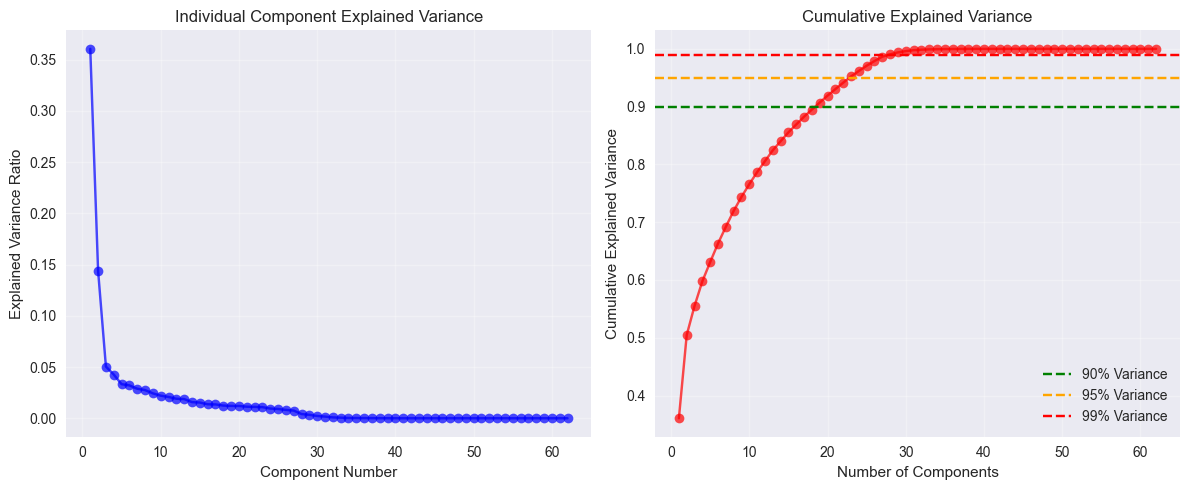


PCA Results:
Original features: 62
PCA components (95% variance): 23
Dimension reduction: 39
Variance captured: 0.9523
✓ PCA transformation completed

Top 5 most influential original features for first 3 components:

PC1 (explains 0.361 variance):
  tenure_x_monthly: 0.207
  poly_tenure MonthlyCharges: 0.207
  TotalCharges: 0.207
  poly_MonthlyCharges TotalCharges: 0.201
  monthly_x_total: 0.201

PC2 (explains 0.144 variance):
  Contract: 0.230
  label_Contract: 0.230
  onehot_InternetService_No: 0.229
  binned_equal_width_MonthlyCharges_0.0: 0.226
  onehot_InternetService_Fiber optic: 0.224

PC3 (explains 0.050 variance):
  binned_equal_freq_TotalCharges_2.0: 0.339
  InternetService: 0.339
  binned_equal_freq_TotalCharges_0.0: 0.292
  binned_custom_tenure_bins_0: 0.249
  onehot_InternetService_No: 0.226


In [38]:
# Standardize features before PCA (PCA is sensitive to scale)
scaler_pca = StandardScaler()
X_train_scaled = scaler_pca.fit_transform(X_train)
X_test_scaled = scaler_pca.transform(X_test)

# Apply PCA to find optimal number of components
pca_full = PCA()
pca_full.fit(X_train_scaled)

# Calculate cumulative explained variance
explained_variance_ratio = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Find optimal number of components for different variance thresholds
variance_thresholds = [0.90, 0.95, 0.99]
optimal_components = {}

for threshold in variance_thresholds:
    n_components = np.argmax(cumulative_variance >= threshold) + 1
    optimal_components[threshold] = n_components
    print(f"Components needed for {threshold*100}% variance: {n_components}")

# Visualize explained variance
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, 'bo-', alpha=0.7)
plt.xlabel('Component Number')
plt.ylabel('Explained Variance Ratio')
plt.title('Individual Component Explained Variance')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'ro-', alpha=0.7)
plt.axhline(y=0.90, color='g', linestyle='--', label='90% Variance')
plt.axhline(y=0.95, color='orange', linestyle='--', label='95% Variance')
plt.axhline(y=0.99, color='r', linestyle='--', label='99% Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Apply PCA with optimal number of components (95% variance threshold)
optimal_n_components = optimal_components[0.95]
pca_optimal = PCA(n_components=optimal_n_components)

X_train_pca = pca_optimal.fit_transform(X_train_scaled)
X_test_pca = pca_optimal.transform(X_test_scaled)

print(f"\nPCA Results:")
print(f"Original features: {X_train.shape[1]}")
print(f"PCA components (95% variance): {optimal_n_components}")
print(f"Dimension reduction: {X_train.shape[1] - optimal_n_components}")
print(f"Variance captured: {pca_optimal.explained_variance_ratio_.sum():.4f}")

# Create PCA feature names
pca_feature_names = [f'PC{i+1}' for i in range(optimal_n_components)]
X_train_pca_df = pd.DataFrame(X_train_pca, columns=pca_feature_names, index=X_train.index)
X_test_pca_df = pd.DataFrame(X_test_pca, columns=pca_feature_names, index=X_test.index)

print(f"✓ PCA transformation completed")

# Show most important original features for top components
print(f"\nTop 5 most influential original features for first 3 components:")
feature_importance_pca = pd.DataFrame(
    pca_optimal.components_[:3].T,
    columns=['PC1', 'PC2', 'PC3'],
    index=X_train.columns
)

for i, pc in enumerate(['PC1', 'PC2', 'PC3']):
    print(f"\n{pc} (explains {pca_optimal.explained_variance_ratio_[i]:.3f} variance):")
    top_features = feature_importance_pca[pc].abs().sort_values(ascending=False).head()
    for feature, importance in top_features.items():
        print(f"  {feature}: {importance:.3f}")

## 📁 Final Output and Saving the Data

After comprehensive feature engineering and selection, we now have multiple feature sets optimized for different modeling approaches. The final engineered dataset will be saved to ensure reproducibility and easy access for the modeling phase.

**Feature selection results summary:**
- **Filter methods**: Statistical significance-based selection
- **Wrapper methods**: Model performance-based selection  
- **PCA**: Dimensionality reduction with variance preservation

We'll save the best performing feature set (wrapper method) as our primary dataset while preserving all versions for comparison.

In [39]:
# Create output directory if it doesn't exist
output_dir = '../Data/output'
os.makedirs(output_dir, exist_ok=True)
print(f"✓ Output directory created/verified: {output_dir}")

# Prepare final datasets with different feature selection methods

# 1. Wrapper Method Features (Primary choice - Random Forest RFE)
print(f"\n📊 Preparing primary dataset with wrapper-selected features:")
X_train_final = pd.DataFrame(X_train_wrapper, columns=wrapper_selected_features, index=X_train.index)
X_test_final = pd.DataFrame(X_test_wrapper, columns=wrapper_selected_features, index=X_test.index)

# Add target variable back
train_final = X_train_final.copy()
train_final['customerID'] = train_processed['customerID']
train_final['Churn'] = train_processed['Churn']

test_final = X_test_final.copy()
test_final['customerID'] = test_processed['customerID'] 
test_final['Churn'] = test_processed['Churn']

print(f"Primary dataset shape: {train_final.shape}")
print(f"Selected features: {len(wrapper_selected_features)}")

# 2. PCA Features (Alternative for dimensionality reduction)
train_pca_final = X_train_pca_df.copy()
train_pca_final['customerID'] = train_processed['customerID']
train_pca_final['Churn'] = train_processed['Churn']

test_pca_final = X_test_pca_df.copy()
test_pca_final['customerID'] = test_processed['customerID']
test_pca_final['Churn'] = test_processed['Churn']

# 3. Filter Methods Features (Statistical selection)
filter_consensus_features = list(common_filter_features)
if len(filter_consensus_features) < 15:  # If too few consensus features, use F-test results
    filter_consensus_features = list(f_selected_features)

X_train_filter = X_train[filter_consensus_features]
X_test_filter = X_test[filter_consensus_features]

train_filter_final = X_train_filter.copy()
train_filter_final['customerID'] = train_processed['customerID']
train_filter_final['Churn'] = train_processed['Churn']

test_filter_final = X_test_filter.copy()
test_filter_final['customerID'] = test_processed['customerID']
test_filter_final['Churn'] = test_processed['Churn']

# Create interim directory for alternative datasets
interim_dir = '../Data/interim'
os.makedirs(interim_dir, exist_ok=True)

# Save all feature selection variants
datasets_to_save = [
    (train_final, test_final, 'wrapper', 'Random Forest RFE selected', output_dir),
    (train_pca_final, test_pca_final, 'pca', 'PCA transformed', interim_dir),
    (train_filter_final, test_filter_final, 'filter', 'Filter methods selected', interim_dir)
]

print(f"\n💾 Saving feature-engineered datasets:")
for train_data, test_data, method, description, save_dir in datasets_to_save:
    # Save training data
    train_filename = f'feature_engineered_train_{method}.csv'
    train_path = os.path.join(save_dir, train_filename)
    train_data.to_csv(train_path, index=False)
    
    # Save test data
    test_filename = f'feature_engineered_test_{method}.csv'
    test_path = os.path.join(save_dir, test_filename)
    test_data.to_csv(test_path, index=False)
    
    dir_name = "output" if save_dir == output_dir else "interim"
    print(f"  ✓ {description} (saved to {dir_name}):")
    print(f"    📁 {train_filename} ({train_data.shape[0]} rows, {train_data.shape[1]} columns)")
    print(f"    📁 {test_filename} ({test_data.shape[0]} rows, {test_data.shape[1]} columns)")

# Save primary dataset as requested filename
primary_train_path = os.path.join(output_dir, 'feature_engineered_train.csv')
train_final.to_csv(primary_train_path, index=False)
print(f"\n🎯 Primary dataset saved as: feature_engineered_train.csv")

# Create feature selection summary report
feature_summary = {
    'Total Original Features': X_train.shape[1],
    'Wrapper Selected (RF RFE)': len(wrapper_selected_features),
    'Filter Selected (F-test)': len(f_selected_features),
    'Filter Selected (Mutual Info)': len(mi_selected_features),
    'Filter Selected (Correlation)': len(corr_selected_features),
    'PCA Components (95% var)': optimal_n_components,
    'Common Filter Features': len(common_filter_features),
    'Common RFE Features': len(common_rfe_features)
}

summary_df = pd.DataFrame(list(feature_summary.items()), columns=['Method', 'Feature_Count'])
summary_path = os.path.join(output_dir, 'feature_selection_summary.csv')
summary_df.to_csv(summary_path, index=False)

print(f"\n📋 Feature Selection Summary:")
for method, count in feature_summary.items():
    print(f"  {method}: {count}")

print(f"\n🎉 FEATURE ENGINEERING AND SELECTION COMPLETE!")
print(f"📁 Primary dataset saved in: {output_dir}")
print(f"📁 Alternative datasets saved in: {interim_dir}")
print(f"🎯 Primary modeling dataset: feature_engineered_train.csv")
print(f"📊 Feature summary report: feature_selection_summary.csv")

✓ Output directory created/verified: ../Data/output

📊 Preparing primary dataset with wrapper-selected features:
Primary dataset shape: (5625, 22)
Selected features: 20

💾 Saving feature-engineered datasets:
  ✓ Random Forest RFE selected (saved to output):
    📁 feature_engineered_train_wrapper.csv (5625 rows, 22 columns)
    📁 feature_engineered_test_wrapper.csv (1407 rows, 22 columns)
  ✓ Random Forest RFE selected (saved to output):
    📁 feature_engineered_train_wrapper.csv (5625 rows, 22 columns)
    📁 feature_engineered_test_wrapper.csv (1407 rows, 22 columns)
  ✓ PCA transformed (saved to interim):
    📁 feature_engineered_train_pca.csv (5625 rows, 25 columns)
    📁 feature_engineered_test_pca.csv (1407 rows, 25 columns)
  ✓ PCA transformed (saved to interim):
    📁 feature_engineered_train_pca.csv (5625 rows, 25 columns)
    📁 feature_engineered_test_pca.csv (1407 rows, 25 columns)
  ✓ Filter methods selected (saved to interim):
    📁 feature_engineered_train_filter.csv (5625 